In [1]:
import re
import pandas as pd
import numpy as np
import requests  # just for data retrieval

from scipy import stats

import DEGA

If the source files are not available, execute ```get_data.ipynb``` first.

In [2]:
# https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&col=gd_app_name&status=Approved&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit
hugoGenes = pd.read_csv("hugo_genes.tsv", sep="\t")

In [3]:
# http://www.ensembl.org/biomart/martview/36672061684d6df966acdd4fd8cfe70b?VIRTUALSCHEMANAME=default&ATTRIBUTES=hsapiens_gene_ensembl.default.feature_page.ensembl_gene_id|hsapiens_gene_ensembl.default.feature_page.ensembl_transcript_id|hsapiens_gene_ensembl.default.feature_page.ensembl_peptide_id|hsapiens_gene_ensembl.default.feature_page.external_gene_name&FILTERS=&VISIBLEPANEL=linkpanel
ensemblId2geneName = pd.read_csv("ensemblId2geneName.tsv", sep="\t").set_index("Gene stable ID")["Gene name"].to_dict()

In [4]:
phenotypes = pd.read_csv("GBM_phenotypes.tsv", index_col=0, sep="\t")

In [5]:
expression_data = pd.read_csv("GBM_raw_counts.tsv.gz", index_col=0, sep="\t").drop("gene_name", axis=1)
expression_data.index = [s.split(".")[0] for s in expression_data.index]
expression_data.index = expression_data.index.map(ensemblId2geneName)  # map index to gene symbol
expression_data = expression_data[expression_data.index.isin(hugoGenes["Approved symbol"])]
expression_data = expression_data.dropna()
expression_data = expression_data.loc[expression_data.index.notna()]
expression_data = expression_data[~expression_data.index.duplicated(keep=False)]  # drop all rows having a duplicate gene name
expression_data = expression_data.astype("int")

In [6]:
print("Analysing GBM dataset")
geneCounts = expression_data
phenotypeData = phenotypes
# filter and sort geneCounts columns on the basis of phenotypeData index
# (they have to be in the same order)
geneCounts = geneCounts[list(set(geneCounts.columns).intersection(phenotypeData.index))]
phenotypeData = phenotypeData.loc[list(set(geneCounts.columns).intersection(phenotypeData.index))]

# filter geneCounts removing genes having a small interquartile range or having more than 25% of zero values 
iqr = stats.iqr(geneCounts, axis=1)  # interquartile range
iqr = stats.iqr(geneCounts, axis=1)  # interquartile range
n_samples = geneCounts.shape[1]
non_zero = (geneCounts != 0).sum(axis=1)/n_samples
iqr_threshold = min(iqr[iqr != 0])  # choose as threshold the lowest value that is greater than 0
non_zero_threshold = 0.25
geneCounts = geneCounts[(iqr > iqr_threshold) & (non_zero > non_zero_threshold)]

dega = DEGA.dataset(geneCounts, phenotypeData, designFormula="sample_type")
dega.analyse(lfcThreshold=1, alpha=0.01)
dega.summary

Analysing GBM dataset


Loading Data
DEGA Dataset
Genes with non-zero read counts: 17798
Number of samples: 175

Estimating Dispersions
Hypothesis Testing
Refitting Without Outliers
Adjusting for Outliers
Done!
DEGA Dataset
Genes with non-zero read counts: 17798
Number of samples: 175
Adjusted P-Value<0.01, LFC<1
Upregulated: 1063, 5.97%
Downregulated: 731, 4.11%
Outliers: 0, 0.0%
Low counts: 0, 0.0%



<Axes: title={'center': 'Adjusted P-Value<0.01, LFC>1, UP: 1063, DOWN: 731'}, xlabel='log2 Fold Change', ylabel='-log10 Adjusted P-Value'>

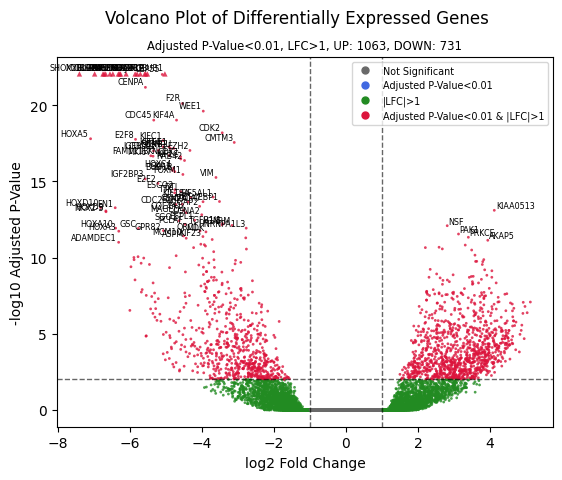

In [7]:
dega.plotVolcano()

In [8]:
switch_genes = dega.identifySwitchGenes(significanceThreshold=0.01, ratioLargestComponent=0.95)

determine correlation threshold:  47%|████▋     | 197/421 [55:27<1:03:03, 16.89s/it]


In [9]:
switch_genes

array(['PTBP1', 'VIM', 'HMG20B', 'GNAI3', 'CCDC80', 'RBBP8', 'TGIF2',
       'TRIP10', 'BCL2L12', 'TNFRSF19', 'SMO', 'TRIM5', 'TGFB1I1',
       'CMTM3', 'RAB13', 'PDIA4', 'WEE1', 'FAM111A', 'SHOX2', 'PLEKHF2',
       'TGIF1', 'F2R', 'EPHB4'], dtype=object)

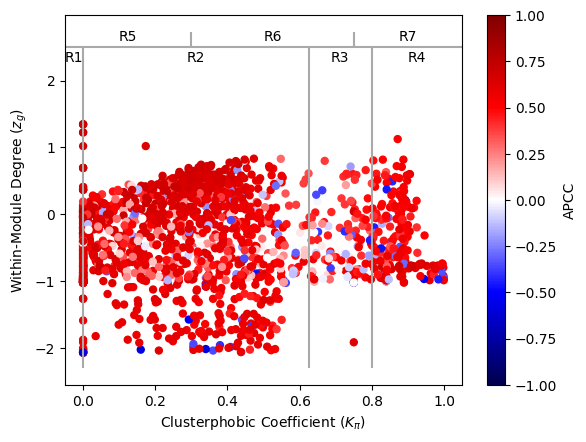

In [10]:
dega._side.plot_heatmap()

### The switch genes identification function of DEGA can also be used as a standalone module

In this case the expression data and significant genes must be provided.

In [11]:
from DEGA import SIDE

In [12]:
significantGenes = dega.significantGenes
counts = dega.transformCounts()  # expression data
counts = counts.loc[list(set(counts.index).intersection(significantGenes))]  # keep only counts of significant genes
significantGenes = counts.index  # because reordered when intersecting sets

In [13]:
side = SIDE(counts, significantGenes)
switch_genes = side.identifySwitchGenes(significanceThreshold=0.01, ratioLargestComponent=0.95)

determine correlation threshold:  47%|████▋     | 197/421 [53:09<1:00:26, 16.19s/it]


In [14]:
switch_genes

array(['EPHB4', 'SHOX2', 'PTBP1', 'CCDC80', 'CMTM3', 'TGFB1I1', 'GNAI3',
       'TNFRSF19', 'PLEKHF2', 'RAB13', 'FAM111A', 'TGIF1', 'PDIA4',
       'HMG20B', 'SMO', 'RBBP8', 'TRIM5', 'VIM', 'BCL2L12', 'WEE1',
       'TGIF2', 'TRIP10', 'F2R'], dtype=object)

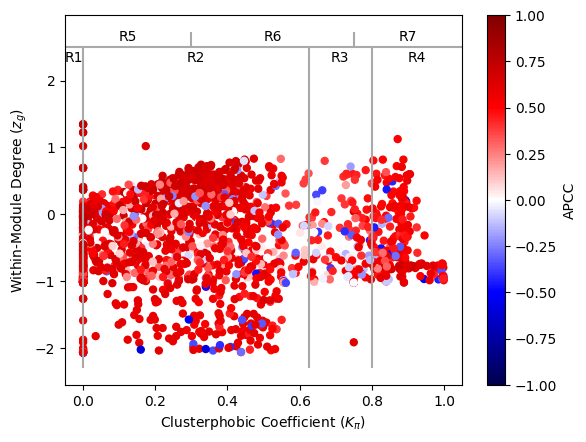

In [15]:
side.plot_heatmap()